In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
# import fitsio
from astropy.table import Table
import sys, os, time, gc, warnings

from run_rf_photoz import get_radius, compute_photoz, nmad

__Specify which data release of Legacy Survey__

In [2]:
# dr = 6 # dr6
dr = 7 # dr7

__Load data__

In [3]:
cat = Table.read('data/ztf19aathmll_host.csv')
cat = cat.filled(-99)

In [4]:
# print(cat.colnames)
cat

ra,dec,mjd_min,mjd_max,glon,glat,elon,elat,brickid,objid,ra_ivar,dec_ivar,bx,by,dchisq_1,dchisq_2,dchisq_3,dchisq_4,dchisq_5,ebv,ref_id,pmra,pmdec,parallax,pmra_ivar,pmdec_ivar,parallax_ivar,ref_epoch,gaia_phot_g_mean_mag,gaia_phot_g_mean_flux_over_error,gaia_phot_bp_mean_mag,gaia_phot_bp_mean_flux_over_error,gaia_phot_rp_mean_mag,gaia_phot_rp_mean_flux_over_error,gaia_astrometric_excess_noise,gaia_astrometric_excess_noise_sig,gaia_astrometric_weight_al,flux_g,flux_r,flux_z,flux_w1,flux_w2,flux_w3,flux_w4,flux_ivar_g,flux_ivar_r,flux_ivar_z,flux_ivar_w1,flux_ivar_w2,flux_ivar_w3,flux_ivar_w4,fiberflux_u,fiberflux_g,fiberflux_r,fiberflux_i,fiberflux_z,fiberflux_y,fibertotflux_u,fibertotflux_g,fibertotflux_r,fibertotflux_i,fibertotflux_z,fibertotflux_y,mw_transmission_g,mw_transmission_r,mw_transmission_z,mw_transmission_w1,mw_transmission_w2,mw_transmission_w3,mw_transmission_w4,rchisq_g,rchisq_r,rchisq_z,rchisq_w1,rchisq_w2,rchisq_w3,rchisq_w4,fracflux_g,fracflux_r,fracflux_z,fracflux_w1,fracflux_w2,fracflux_w3,fracflux_w4,fracmasked_g,fracmasked_r,fracmasked_z,fracin_g,fracin_r,fracin_z,psfsize_g,psfsize_r,psfsize_z,psfdepth_g,psfdepth_r,psfdepth_z,galdepth_g,galdepth_r,galdepth_z,fracdev,fracdev_ivar,shapeexp_r,shapeexp_r_ivar,shapeexp_e1,shapeexp_e1_ivar,shapeexp_e2,shapeexp_e2_ivar,shapedev_r,shapedev_r_ivar,shapedev_e1,shapedev_e1_ivar,shapedev_e2,shapedev_e2_ivar,htm9,ring256,nest4096,decals_id,mag_g,mag_r,mag_z,mag_w1,mag_w2,mag_w3,mag_w4,dered_flux_g,dered_flux_r,dered_flux_z,dered_flux_w1,dered_flux_w2,dered_flux_w3,dered_flux_w4,dered_mag_g,dered_mag_r,dered_mag_z,dered_mag_w1,dered_mag_w2,dered_mag_w3,dered_mag_w4,snr_g,snr_r,snr_z,snr_w1,snr_w2,snr_w3,snr_w4,g_r,r_z,z_w1,w1_w2,w2_w3,w3_w4,random_id,release,brick_primary,brightstarinblob,gaia_pointsource,gaia_phot_g_n_obs,gaia_phot_bp_n_obs,gaia_phot_rp_n_obs,gaia_phot_variable_flag,gaia_astrometric_n_obs_al,gaia_astrometric_n_good_obs_al,gaia_duplicated_source,nobs_g,nobs_r,nobs_z,nobs_w1,nobs_w2,nobs_w3,nobs_w4,anymask_g,anymask_r,anymask_z,allmask_g,allmask_r,allmask_z,wisemask_w1,wisemask_w2,brickname,type,ref_cat,wise_coadd_id
float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,int64,int64,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,str8,str3,int64,str8
266.204932293,16.5228246279,57829.3505693,57959.1214914,40.8546018493,21.9760419062,265.255480374,39.8996385209,425237,4647,30409900000.0,10288600000.0,319.993,2113.53,3461.53,5118.51,5572.1,5646.7,4574.39,0.08246,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.88583,6.21489,8.4989,2.25261,3.53152,-19.9077,-751.073,241.826,44.9474,3.76895,3.2124,0.689963,0.001107,2.5e-05,0,0.638855,1.02177,0,1.39727,0,0,0.638855,1.02177,0,1.39727,0,0.783411,0.848379,0.912129,0.986123,0.991455,0.998171,0.999309,0.926327,1.18067,0.968202,2.34684,0.795544,0.570258,0.13075,0.00

In [5]:
# Rename columns
for temp in cat.colnames:
    cat.rename_column(temp, temp.upper())
    
columns = ['RA', 'DEC', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2',
'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2',
'NOBS_G', 'NOBS_R', 'NOBS_Z',
'TYPE', 'EBV', 'FRACDEV',
'SHAPEDEV_R', 'SHAPEDEV_E1', 'SHAPEDEV_E2', 'SHAPEEXP_R', 'SHAPEEXP_E1', 'SHAPEEXP_E2',
'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2',
]

cat_new = cat[columns]

cat_new['DCHISQ'] = np.zeros((1, 5))
cat_new['DCHISQ'][:, 0] = cat['DCHISQ_1']
cat_new['DCHISQ'][:, 1] = cat['DCHISQ_2']
cat_new['DCHISQ'][:, 2] = cat['DCHISQ_3']
cat_new['DCHISQ'][:, 3] = cat['DCHISQ_4']
cat_new['DCHISQ'][:, 4] = cat['DCHISQ_5']

cat = cat_new.copy()

In [6]:
# Apply extinction correction
cat['FLUX_G'] = cat['FLUX_G']/cat['MW_TRANSMISSION_G']
cat['FLUX_R'] = cat['FLUX_R']/cat['MW_TRANSMISSION_R']
cat['FLUX_Z'] = cat['FLUX_Z']/cat['MW_TRANSMISSION_Z']
cat['FLUX_W1'] = cat['FLUX_W1']/cat['MW_TRANSMISSION_W1']
cat['FLUX_W2'] = cat['FLUX_W2']/cat['MW_TRANSMISSION_W2']

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cat['gmag'] = 22.5 - 2.5*np.log10(cat['FLUX_G'])
    cat['rmag'] = 22.5 - 2.5*np.log10(cat['FLUX_R'])
    cat['zmag'] = 22.5 - 2.5*np.log10(cat['FLUX_Z'])
    cat['w1mag'] = 22.5 - 2.5*np.log10(cat['FLUX_W1'])
    cat['w2mag'] = 22.5 - 2.5*np.log10(cat['FLUX_W2'])
    cat['gmagerr'] = 1/np.sqrt(cat['FLUX_IVAR_G'])/cat['FLUX_G']
    cat['rmagerr'] = 1/np.sqrt(cat['FLUX_IVAR_R'])/cat['FLUX_R']
    cat['zmagerr'] = 1/np.sqrt(cat['FLUX_IVAR_Z'])/cat['FLUX_Z']
    cat['w1magerr'] = 1/np.sqrt(cat['FLUX_IVAR_W1'])/cat['FLUX_W1']
    cat['w2magerr'] = 1/np.sqrt(cat['FLUX_IVAR_W2'])/cat['FLUX_W2']

In [8]:
cat

RA,DEC,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,NOBS_G,NOBS_R,NOBS_Z,TYPE,EBV,FRACDEV,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,DCHISQ [5],gmag,rmag,zmag,w1mag,w2mag,gmagerr,rmagerr,zmagerr,w1magerr,w2magerr
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,str3,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
266.204932293,16.5228246279,4.96014224973,7.32560565502,9.31765134098,2.284309361,3.5619569219,241.826,44.9474,3.76895,3.2124,0.689963,2,1,1,EXP,0.08246,0,0,0,0,2.41568,0.431873,0.195617,0.783411,0.848379,0.912129,0.986123,0.991455,3461.53 .. 4574.39,20.761264671,20.3378911589,20.0767338613,21.6031127013,21.1207783429,0.0129644582123,0.0203612378022,0.0552819503451,0.244247581387,0.337985785881


__Check the photo-z quality cuts (no effect on the photo-z)__

In [9]:
# Quality in r: SNR_R > 0 && RFLUX > 0
mask = (cat['FLUX_R']>0) & (cat['FLUX_IVAR_R']>0)
print('Quality in r:', mask)

# Quality in z: SNR_Z > 0 && ZFLUX > 0
mask &= (cat['FLUX_Z']>0) & (cat['FLUX_IVAR_Z']>0)
print('& Quality in z:', mask)

# Quality in W1: FLUX_IVAR_W1 > 0 && W1FLUX > 0
mask &= (cat['FLUX_W1']>0) & (cat['FLUX_IVAR_W1']>0)
print('& Quality in W1:', mask)

############################## Broad cuts ##############################

# None-stellar color: (z-w1) > 0.8*(r-z) - 1.0 => -0.8*r + 1.8*z - W1 > -1.0
mask &= (cat['FLUX_R']**(-0.8) * cat['FLUX_Z']**1.8 / cat['FLUX_W1'] < 10**(-0.4*(-1.0)))
print('& None-stellar color:', mask)

############################## Include BGS targets ##############################

mask_bgs = np.ones(len(cat), dtype=bool)

# Quality in r: SNR_R > 0 && RFLUX > 0
mask_bgs &= (cat['FLUX_R']>0) & (cat['FLUX_IVAR_R']>0)
# magnitude limit r<20.
mask_bgs &= (cat['FLUX_R'] > 10**(0.4*(22.5-20.0))) # r<20.0
# Remove PSF objects
mask_bgs &= (cat['TYPE']!='PSF ') & (cat['TYPE']!='PSF')
print('BGS cut:', mask)

mask |= mask_bgs
print('All photo-z quality cuts:', mask)

Quality in r: [ True]
& Quality in z: [ True]
& Quality in W1: [ True]
& None-stellar color: [False]
BGS cut: [False]
All photo-z quality cuts: [False]


__Compute photo-z__

In [10]:
# Add half-light radius for photo-z estimation
cat['radius'] = get_radius(cat)

Computing radius for COMP objects
0
0 objects with no solution in r < 30 arcsec


In [11]:
cat_pz = compute_photoz(cat, dr, n_perturb=20)

Computing photo-z's and errors with perturbed photometry
0 / 1000
20 / 1000
40 / 1000
60 / 1000
80 / 1000
100 / 1000
120 / 1000
140 / 1000
160 / 1000
180 / 1000
200 / 1000
220 / 1000
240 / 1000
260 / 1000
280 / 1000
300 / 1000
320 / 1000
340 / 1000
360 / 1000
380 / 1000
400 / 1000
420 / 1000
440 / 1000
460 / 1000
480 / 1000
500 / 1000
520 / 1000
540 / 1000
560 / 1000
580 / 1000
600 / 1000
620 / 1000
640 / 1000
660 / 1000
680 / 1000
700 / 1000
720 / 1000
740 / 1000
760 / 1000
780 / 1000
800 / 1000
820 / 1000
840 / 1000
860 / 1000
880 / 1000
900 / 1000
920 / 1000
940 / 1000
960 / 1000
980 / 1000
Matching to truth table
0 matches
0 matches


In [12]:
cat_pz

z_phot,z_phot_err,z_phot_all [1000],z_spec,survey,training
float32,float32,float32,float32,str7,bool
0.120793,0.0673434,0.202228 .. 0.193685,-99.0,,False


In [13]:
print('Mean =   {:.4f}'.format(np.mean(cat_pz['z_phot_all'][0])))
print('Median = {:.4f}'.format(np.median(cat_pz['z_phot_all'][0])))
print()
print('STD =  {:.4f}'.format(np.std(cat_pz['z_phot_all'][0])))
print('NMAD = {:.4f}'.format(nmad(cat_pz['z_phot_all'][0])))
print('16th percentile = {:.4f}'.format(np.percentile(cat_pz['z_phot_all'][0], 16)))
print('84th percentile = {:.4f}'.format(np.percentile(cat_pz['z_phot_all'][0], 84)))
print('2.5th percentile =  {:.4f}'.format(np.percentile(cat_pz['z_phot_all'][0], 2.5)))
print('97.5th percentile = {:.4f}'.format(np.percentile(cat_pz['z_phot_all'][0], 97.5)))

Mean =   0.1208
Median = 0.1093

STD =  0.0673
NMAD = 0.0326
16th percentile = 0.0799
84th percentile = 0.1528
2.5th percentile =  0.0521
97.5th percentile = 0.2818


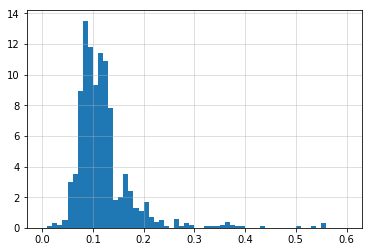

In [14]:
plt.hist(cat_pz['z_phot_all'][0], 60, range=(0, 0.6), normed=True)
plt.grid(alpha=0.5);

In [15]:
mask = cat_pz['z_phot_all'][0]<0.1
print('Probability of z<0.1:', np.sum(mask)/len(mask))

Probability of z<0.1: 0.418
